In [10]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# -----------------------------
# 1. 파일 불러오기
# -----------------------------
file = open('WISDM_ar_v1.1_raw.txt')
lines = file.readlines()

processedList = []
for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0].strip()
        if last == '':
            break
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

columns = ['user', 'activity', 'time', 'x', 'y', 'z']
df = pd.DataFrame(data=processedList, columns=columns)

# -----------------------------
# 2. 데이터 전처리
# -----------------------------
df['x'] = df['x'].astype('float')
df['y'] = df['y'].astype('float')
df['z'] = df['z'].astype('float')

# 라벨 인코딩
label = LabelEncoder()
df['activity'] = label.fit_transform(df['activity'])


Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


In [12]:
df

,user,activity,time,x,y,z
0,33,1,49105962326000,-0.694638,12.680544,0.503953
1,33,1,49106062271000,5.012288,11.264028,0.953424
2,33,1,49106112167000,4.903325,10.882658,-0.081722
3,33,1,49106222305000,-0.612916,18.496431,3.023717
4,33,1,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
343411,11,5,1786872234000,0.310000,10.730000,0.040861
343412,11,5,1786922282000,2.760000,10.950000,0.844462
343413,11,5,1786972392000,0.800000,10.150000,1.334794
343414,11,5,1787022227000,-1.570000,8.690000,1.416516


In [14]:
# -----------------------------
# 3. 특징(X)과 라벨(y)
# -----------------------------
X = df[['x', 'y', 'z']]
y = df['activity']

scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data=X, columns=['x', 'y', 'z'])
scaled_X['label'] = y.values


In [18]:

# -----------------------------
# 4. 슬라이딩 윈도우 함수
# -----------------------------
Fs = 20
frame_size = Fs*4  # 80
hop_size = Fs*2    # 40

def get_frames(df, frame_size, hop_size):
    N_FEATURES = 3
    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i:i+frame_size]
        y = df['y'].values[i:i+frame_size]
        z = df['z'].values[i:i+frame_size]
        label = stats.mode(df['label'][i:i+frame_size], keepdims=True).mode[0]
        frames.append([x, y, z])
        labels.append(label)
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)
    return frames, labels

X, y = get_frames(scaled_X, frame_size, hop_size)


In [20]:

# -----------------------------
# 5. 학습/테스트 데이터 분리
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# CNN 입력형태로 reshape
X_train = X_train.reshape(X_train.shape[0], frame_size, 3, 1)
X_test = X_test.reshape(X_test.shape[0], frame_size, 3, 1)


In [22]:
# -----------------------------
# 6. 2D CNN 모델 구성
# -----------------------------
num_classes = len(np.unique(y))  # 전체 클래스 수

model = Sequential()
model.add(Conv2D(16, (2,2), activation='relu', input_shape=X_train[0].shape))
model.add(Dropout(0.1))
model.add(Conv2D(32, (2,2), activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 79, 2, 16)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 79, 2, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 78, 1, 32)      │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 78, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2496)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       159,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,358 (634.21 KB)

 Trainable params: 162,358 (634.21 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# -----------------------------
# 7. 모델 학습
# -----------------------------
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5793 - loss: 1.0351 - val_accuracy: 0.8212 - val_loss: 0.4854
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8119 - loss: 0.5100 - val_accuracy: 0.8474 - val_loss: 0.3698
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8467 - loss: 0.3962 - val_accuracy: 0.8742 - val_loss: 0.3186
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8722 - loss: 0.3294 - val_accuracy: 0.9010 - val_loss: 0.2706
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8829 - loss: 0.2942 - val_accuracy: 0.9126 - val_loss: 0.2429
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8937 - loss: 0.2647 - val_accuracy: 0.9150 - val_loss: 0.2346
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9059 - loss: 0.2467 - val_accuracy: 0.9156 - val_loss: 0.2295
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9138 - loss: 0.2112 - val_accuracy: 0.

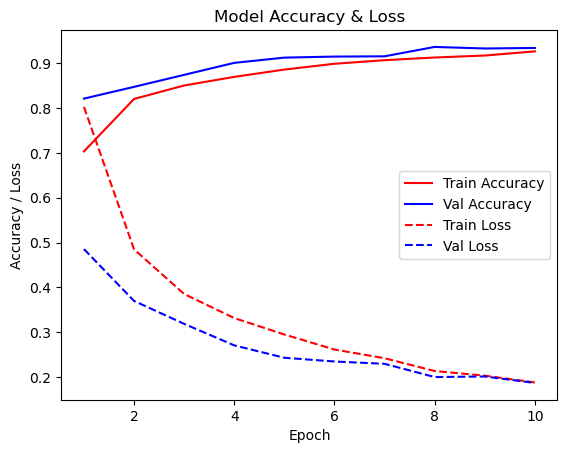

In [26]:

# -----------------------------
# 8. 학습 곡선 시각화
# -----------------------------
def plot_learningCurve(history, epochs):
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'], 'r', label='Train Accuracy')
    plt.plot(epoch_range, history.history['val_accuracy'], 'b', label='Val Accuracy')
    plt.plot(epoch_range, history.history['loss'], 'r--', label='Train Loss')
    plt.plot(epoch_range, history.history['val_loss'], 'b--', label='Val Loss')
    plt.title('Model Accuracy & Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy / Loss')
    plt.legend()
    plt.show()

plot_learningCurve(history, 10)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.86      0.69      0.77       167
           1       0.98      0.99      0.99       646
           2       0.96      1.00      0.98        23
           3       0.94      0.94      0.94        18
           4       0.70      0.82      0.76       176
           5       0.97      0.97      0.97       687

    accuracy                           0.93      1717
   macro avg       0.90      0.90      0.90      1717
weighted avg       0.94      0.93      0.93      1717



(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

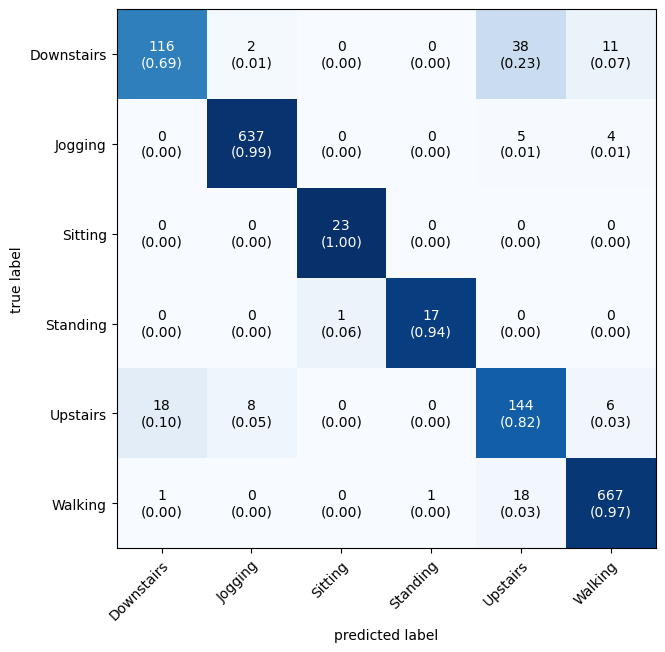

In [28]:
# -----------------------------
# 9. 모델 평가
# -----------------------------
y_pred = model.predict(X_test).argmax(axis=-1)
print(classification_report(y_test, y_pred))

mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))